In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.5 MB/s eta 0:00:00


In [2]:
# Bibliotecas para manipulação e processamento de dados
import numpy as np 
import pandas as pd 
import torch
import re

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Pacotes para manipulação das variáveis
from sklearn.model_selection import train_test_split

# Pacotes para modelagem
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import pipeline

# Pacotes para avaliação dos resultados
from sklearn.metrics import confusion_matrix, classification_report



# 1-) Leitura dos Dados

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
tweets_df = pd.read_csv("/content/drive/MyDrive/Sentimental-Analisys-Tweets/Data/kaggle_en_tweets.csv")
tweets_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


# 2-) Preprocessing

In [6]:
# Transformando todos os textos em caracteres minusculos
tweets_df.text = tweets_df.text.str.lower()
tweets_df.selected_text = tweets_df.selected_text.str.lower()
tweets_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","sons of ****,",negative


In [7]:
# Retirada do valor nulo para o texto
display(tweets_df[tweets_df.text.isnull()])
tweets_df.dropna(subset=['text'],inplace=True)
tweets_df.info()

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [8]:
# Analisando alguns textos
tweets_df.text.values[:25]

array([' i`d have responded, if i were going',
       ' sooo sad i will miss you here in san diego!!!',
       'my boss is bullying me...', ' what interview! leave me alone',
       ' sons of ****, why couldn`t they put them on the releases we already bought',
       'http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth',
       '2am feedings for the baby are fun when he is all smiles and coos',
       'soooo high', ' both of you',
       ' journey!? wow... u just became cooler.  hehe... (is that possible!?)',
       ' as much as i love to be hopeful, i reckon the chances are minimal =p i`m never gonna get my cake and stuff',
       'i really really like the song love story by taylor swift',
       'my sharpie is running dangerously low on ink',
       'i want to go to music tonight but i lost my voice.',
       'test test from the lg env2', 'uh oh, i am sunburned',
       ' s`ok, trying to plot alternatives as we speak *sigh*',
       'i`ve been

* Retirar espaços exagerados
* Retirar pontuação e "stop words" como: I, the e etc ( Não comprometem o sentido da frase se eliminá-las)
* Retirar simbologia de emoticos como: =p , <3 e etc
* Retirar hyperlinks
* Retirar asteriscos de palavras "censuradas"

In [9]:
# Tratando os dados
TROCAR_POR_ESPACO = re.compile('[/(){}\[\]\|@,;]')
REMOVER = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    text = re.sub('(http)\S*', '', text) # Retirando os hiperlinks
    text = REMOVER.sub('', text) 
    text = TROCAR_POR_ESPACO.sub(' ', text)
    text = re.sub('[0-9]', '', text)
    return text

tweets_df["clean_txt"] = tweets_df.text.apply(lambda t: clean_text(t))
tweets_df["select_clean_txt"] = tweets_df.selected_text.apply(lambda t: clean_text(t))
tweets_df

,textID,text,selected_text,sentiment,clean_txt,select_clean_txt
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,id have responded if i were going,id have responded if i were going
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,sooo sad i will miss you here in san diego,sooo sad
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,leave me alone
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","sons of ****,",negative,sons of why couldnt they put them on the rel...,sons of
...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on denver husband l...,d lost,negative,wish we could come see u on denver husband l...,d lost
27477,4f4c4fc327,i`ve wondered about rake to. the client has ...,", don`t force",negative,ive wondered about rake to the client has ma...,dont force
27478,f67aae2310,yay good for both of you. enjoy the break - y...,yay good for both of you.,positive,yay good for both of you enjoy the break you...,yay good for both of you
27479,ed167662a5,but it was worth it ****.,but it was worth it ****.,positive,but it was worth it,but it was worth it


In [10]:
# Limpeza dos tweets processados que ficaram sem texto
tweets_df = tweets_df[tweets_df.clean_txt.str.len() != 0]
tweets_df.head()

,textID,text,selected_text,sentiment,clean_txt,select_clean_txt
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,id have responded if i were going,id have responded if i were going
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,sooo sad i will miss you here in san diego,sooo sad
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,leave me alone
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","sons of ****,",negative,sons of why couldnt they put them on the rel...,sons of


# 3-) EDA

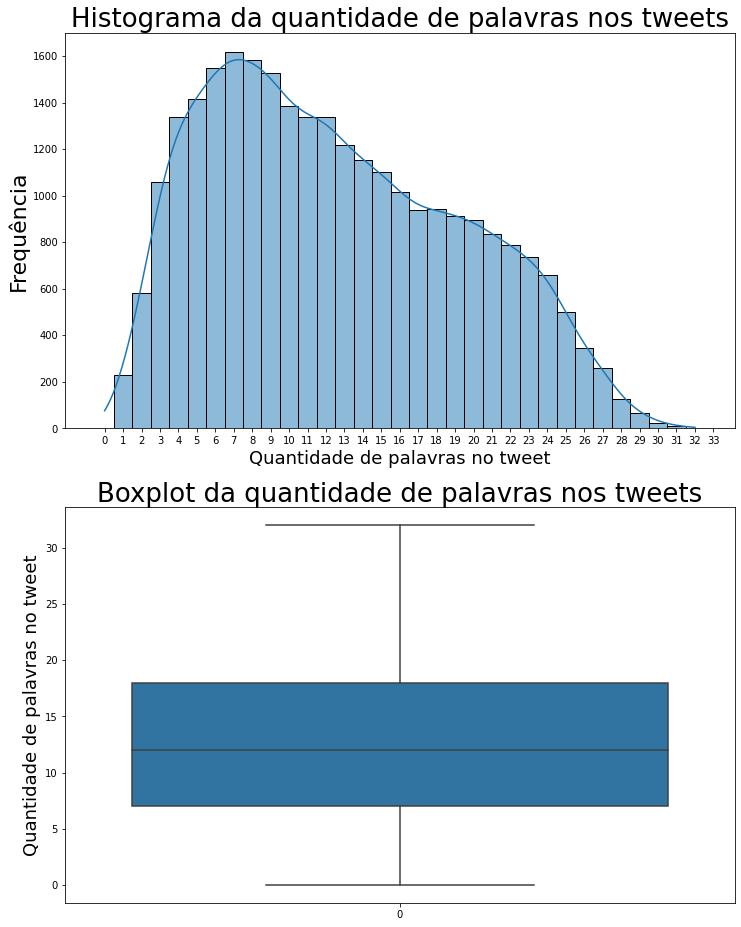

count    27480.000000
mean        12.520961
std          6.762738
min          0.000000
25%          7.000000
50%         12.000000
75%         18.000000
max         32.000000
Name: clean_txt, dtype: float64

In [11]:
# ANÁLISE DOS TAMANHOS DOS TWEETS DO DATASET
size_tweets = tweets_df.clean_txt.apply(lambda t: len(str(t).split()))
fig,ax = plt.subplots(2,1,figsize=(12,16))

# Histograma
sns.histplot(data=size_tweets,common_bins=False,discrete=1,kde=True,ax=ax[0])
ax[0].set_xticks(np.arange(0,34,1))
ax[0].set_ylabel("Frequência",fontsize=22)
ax[0].set_xlabel("Quantidade de palavras no tweet",fontsize=18)
ax[0].set_title("Histograma da quantidade de palavras nos tweets",fontsize=26)

# Boxplot
sns.boxplot(data=size_tweets,ax=ax[1])
ax[1].set_ylabel("Quantidade de palavras no tweet",fontsize=18)
ax[1].set_title("Boxplot da quantidade de palavras nos tweets",fontsize=26)
plt.show()

display(size_tweets.describe())

Insights: No dataset processado
* A maioria dos tweets estão na faixa de 5-9 palavras
* No dataset processado não se estendem para mais de 33 palavras, baixa dispersão, tendo em vista q o Twitter permite ate 240 caracteres.
* Assimetria para tweets mais curtos.

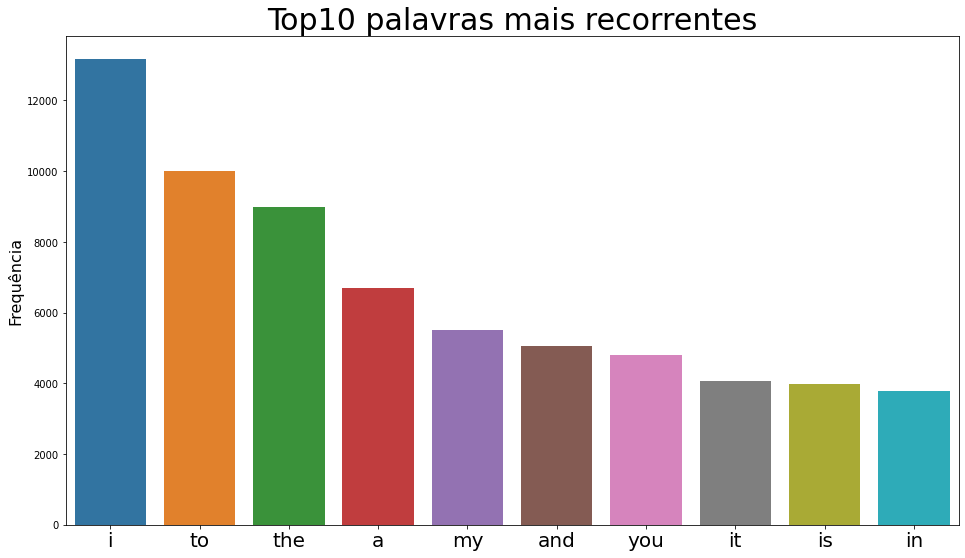

In [12]:
# ANÁLISE DAS PALAVRAS MAIS RECORRENTES

caracteres = tweets_df.clean_txt.apply(lambda t: str(t).split())
caracteres = caracteres.to_frame().explode('clean_txt').reset_index()
# Top10 palavras
top_caracteres = caracteres['clean_txt'].value_counts().sort_values(ascending=False).head(10)

fig,ax = plt.subplots(1,1,figsize=(16,9))
sns.barplot(x = top_caracteres.index, y =top_caracteres.values,ax=ax)
ax.set_xticklabels(top_caracteres.index,fontsize=20)
ax.set_ylabel("Frequência",fontsize=16)
ax.set_title("Top10 palavras mais recorrentes",fontsize=30)
plt.show()


Insights: A palavras mais recorrentes são - de modo geral - artigos, preposições e verbos da lingua inglesa. Percebe-se que são vocabulos bastante simples, não excedendo 3 letras.

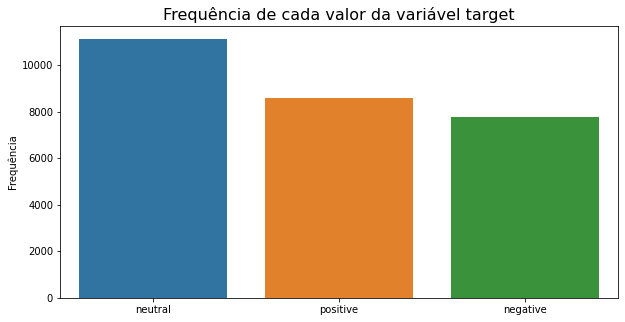

In [13]:
# Balanceamento das classe target
qtd_class = tweets_df.sentiment.value_counts()

fig,ax = plt.subplots(1,1,figsize=(10,5))
sns.barplot(x = qtd_class.index, y =qtd_class.values,ax=ax)
ax.set_ylabel("Frequência",fontsize=10)
ax.set_xticklabels(qtd_class.index,fontsize=10)
ax.set_title("Frequência de cada valor da variável target",fontsize=16)
plt.show()

Insight: Bom balanceamento das classes.

# 4-) Feature Engineering

In [11]:
# Transformação das classes em variaveis dummies
target_class = tweets_df.sentiment
classes_dummies = pd.get_dummies(target_class)
classes_dummies

,negative,neutral,positive
0,0,1,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
27476,1,0,0
27477,1,0,0
27478,0,0,1
27479,0,0,1


In [12]:
# Categorização da variavel dummy criada. 0:Negativa ; 1: Neutra ; 2: Positiva
y = np.argmax(classes_dummies.values,axis=1)
y

array([1, 0, 0, ..., 2, 2, 1])

In [13]:
# Separação dos dados de treino, validação e teste
X = tweets_df.clean_txt.values
y = np.argmax(classes_dummies.values,axis=1)
seed = 42

X_training,X_test,y_training,y_test = train_test_split(X,y,stratify=y,
                                                       random_state = seed, 
                                                       test_size=5000)
print(f'X_training shape:{X_training.shape}')
print(f'X_test shape:{X_test.shape}')
print(f'y_training shape:{y_training.shape}')
print(f'y_test shape:{y_test.shape}')
print("\n")

X_train,X_val,y_train,y_val = train_test_split(X_training,y_training,stratify=y_training,
                                                       random_state = seed, 
                                                       test_size=4000)
print(f'X_train shape:{X_train.shape}')
print(f'X_val shape:{X_val.shape}')
print(f'y_train shape:{y_train.shape}')
print(f'y_val shape:{y_val.shape}')


X_training shape:(22480,)
X_test shape:(5000,)
y_training shape:(22480,)
y_test shape:(5000,)


X_train shape:(18480,)
X_val shape:(4000,)
y_train shape:(18480,)
y_val shape:(4000,)


# 5-) Model

In [17]:
# Extração do tokenizer e modelo, da arquitetura e checkpoint adequado
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# Transformação dos textos usando o tokenizer e criação do tensor no PyTorch
train_input = tokenizer(X_train.tolist(), max_length=30,
                          padding="max_length",truncation =True, 
                          return_tensors='pt')

val_input = tokenizer(X_val.tolist(), max_length=30,
                          padding="max_length",truncation =True, 
                          return_tensors='pt')

test_input= tokenizer(X_test.tolist(), max_length=30,
                          padding="max_length",truncation =True, 
                          return_tensors='pt')

In [19]:
# Definição da Classe herdeira do tipo Dataset do pyTorch
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, input, labels):
        self.input = input
        self.labels = labels

    def __getitem__(self, index):
        item = {key: torch.tensor(value[index]).clone().detach()  for key, value in self.input.items()}
        item['labels'] = torch.tensor(self.labels[index]).clone().detach() 
        return item

    def __len__(self):
        return len(self.labels)
# Transformação de cada dataset no tipo criado
train_dataset = TweetDataset(train_input, y_train)
val_dataset = TweetDataset(val_input, y_val)
test_dataset = TweetDataset(test_input, y_test)

In [20]:
# Definição dos hiperparâmetros
training_args = TrainingArguments("test-trainer")

# Criação do objeto de treino
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

In [ ]:
# Fine-Tune do modelo com os novos dados
trainer.train()

In [15]:
save_model_path = "/content/drive/MyDrive/Sentimental-Analisys-Tweets/Data"

In [24]:
# Salvando o modelo treinado na pasta escolhida
trainer.save_model(save_model_path)

Saving model checkpoint to /content/drive/MyDrive/Sentimental-Analisys-Tweets/Data/teste
Configuration saved in /content/drive/MyDrive/Sentimental-Analisys-Tweets/Data/teste/config.json
Model weights saved in /content/drive/MyDrive/Sentimental-Analisys-Tweets/Data/teste/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/Sentimental-Analisys-Tweets/Data/teste/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Sentimental-Analisys-Tweets/Data/teste/special_tokens_map.json


# 6-) Predictions

In [16]:
# Importando o modelo treinado
path = save_model_path+"/bert_finetuned_tweets"
clf = pipeline("sentiment-analysis", model = path, tokenizer = path)

In [27]:
clf.predict("THIS GONA BE GREAT")

[{'label': 'LABEL_2', 'score': 0.9990861415863037}]

In [ ]:
# Realizando as predições 
predictions_val = clf.predict(X_val.tolist())
predictions_val

In [18]:
# Avaliando as predições feitas
evaluation_val_df = pd.DataFrame(predictions_val)
evaluation_val_df['label'] = evaluation_val_df['label'].apply(lambda l: int(l[-1]))
evaluation_val_df['label_true'] = y_val

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(evaluation_val_df['label_true'],evaluation_val_df['label']))
print(classification_report(evaluation_val_df['label_true'],evaluation_val_df['label']))

[[ 898  204   31]
 [ 221 1213  184]
 [  33  186 1030]]
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1133
           1       0.76      0.75      0.75      1618
           2       0.83      0.82      0.83      1249

    accuracy                           0.79      4000
   macro avg       0.79      0.79      0.79      4000
weighted avg       0.79      0.79      0.79      4000



Insights: Boa performance nas métricas avaliadas. A maioria dos erros está na classificação de Neutros como Positivos e Negativos. 
No que diz respeito a campanhas de marketing digital:

*   O sentimento do tweet ser Positivo ou Negativo e o modelo predize-lo como Neutro não será de grande impacto tendo em vista tweets neutros demonstra, na sua maioria, que fatos estão sendo expostos, não impondo uma tomada de decisão crítica para modificação da campanha. No entanto, ser Negativo e predito como Neutro, esconde críticas e problemas na campanha, sendo um ponto de atenção.

*   A previsão de tweets Neutros como Positivos ou Negativos podem ser mais prejudiciais.
    *   Negativo: A campanha foi pior sucedida do que na realidade, novas medidas críticas seram tomadas, quando não precisava.
    *   Positivo: A campanha foi melhor sucedida do que na realidade. O excesso de confiança numa campanha, quando na realidade não é assim, pode ser bastante comprometedor, sendo outro ponto a se melhorar no modelo.




In [19]:
# Filtragem dos dados os quais a predição foi de Positivo ou Negativo, mas era Neutro.
erros_dataframe = evaluation_val_df[(evaluation_val_df.label!=1) & (evaluation_val_df.label_true==1)]
mask = erros_dataframe.index
display(erros_dataframe)
erros_df = tweets_df[tweets_df.clean_txt.apply(lambda t: t in X_val[mask])]
display(erros_df)

,label,score,label_true
6,0,0.989830,1
12,2,0.988320,1
16,0,0.892856,1
19,0,0.984093,1
27,2,0.986889,1
...,...,...,...
3980,0,0.972927,1
3984,0,0.856510,1
3989,2,0.990234,1
3992,0,0.972833,1


,textID,text,selected_text,sentiment,clean_txt,select_clean_txt
70,4213627c3c,i still smell of smoke #kitchenfire,i still smell of smoke #kitchenfire,neutral,i still smell of smoke #kitchenfire,i still smell of smoke #kitchenfire
216,234093bef1,which means you`re just going to have to come...,which means you`re just going to have to come ...,neutral,which means youre just going to have to come ...,which means youre just going to have to come b...
230,ae21c1ac38,the exception for a short dude: larenz fineass...,the exception for a short dude: larenz fineass...,neutral,the exception for a short dude larenz fineass ...,the exception for a short dude larenz fineass ...
301,519a5d3be7,why not now you made me sad i thought you`d ...,why not now you made me sad i thought you`d be...,neutral,why not now you made me sad i thought youd b...,why not now you made me sad i thought youd be ...
440,4016e4cf72,discovered and are sharing on g reader with ...,discovered and are sharing on g reader with ...,neutral,discovered and are sharing on g reader with ...,discovered and are sharing on g reader with ...
...,...,...,...,...,...,...
26893,e73e7f9815,sang on xbox lips and drunk beer my weekend ro...,sang on xbox lips and drunk beer my weekend ro...,neutral,sang on xbox lips and drunk beer my weekend ro...,sang on xbox lips and drunk beer my weekend ro...
27023,3f1fb0ae3c,oww...just bit my tongue,oww...just bit my tongue,neutral,owwjust bit my tongue,owwjust bit my tongue
27067,c2dfc5875c,"jamie @ sean cody, up for some angry ****?: ja...","amie @ sean cody, up for some angry ****?: jam...",neutral,jamie sean cody up for some angry jamie sea...,amie sean cody up for some angry jamie sean...
27151,cab9203314,wished i watched jon & kate plus 8 on monday,wished i watched jon & kate plus 8 on monday,neutral,wished i watched jon kate plus on monday,wished i watched jon kate plus on monday


Insights: Analisando com mais cuidado os erros que o modelo cometeu fica evidente que a classificação de sentimentos pode ser considerada um processo subjetivo. Em frases como: "oww...just bit my tongue" ou "i still smell of smoke #kitchenfire" podem facilmente ser consideradas mensagens negativas, uma maior acertidão precisaria de um contexto que essas frases foram feitas.